In [1]:
!pip install 'sunpy[all]' 'numpy<1.26' natsort xarray torch codecarbon pandas

In [2]:
import numpy as np
from natsort import natsorted
import xarray as xr

import matplotlib.pyplot as plt
import sunpy.visualization.colormaps as cm
from codecarbon import track_emissions

# Solar Virtual Observatory Challenge

## The Sun

<img src="https://scied.ucar.edu/sites/default/files/styles/extra_large/public/images/Interior_Sun_layers.jpg.webp?itok=MdqlQJwf" width="600">

Sun's Atmosphere:
- Photosphere
- Chromosphere
- Transition Region
- Corona

## Solar Dynamics Observatory

![](https://sdo.gsfc.nasa.gov/assets/img/site/spacecraft_detailed.jpg)

### HMI (Helioseismic and Magnetic Imager)

- Observes Photosphere
- 6173 Å filter $\rightarrow$ Fe I
- Measures Dopplershift $\rightarrow$ Plasma movement $\rightarrow$ Heliseismic activity
- Measures Poalrization and Zeeman splitting $\rightarrow$ Magnetic Field

### EVE (Extreme Ultraviolet Variability Experiment)

- Observes Sun’s corona and transition region
- Measures the solar extreme-ultraviolet (EUV)
- Important for space weather $\rightarrow$ EUV hits Earth's atmosphere

### AIA (Atmospheric Imaging Assembly)

- Observes Chromosphere, Transition Region, and Corona
- 10 different wavelenghts (in this challenge only 9)
- Investigates mechanisms that heat the corona

# Challenge

## a) A virtual observatory

### **Given**: AIA Data from 2010
### **Problem**: Prolonged exposure to intense radiation during a solar maximum has led to the degradation of 8 AIA filters onboard SDO. Only the 94 Å channel remains operational.
### **Task**: Use what you’ve learned in this school to train a deep learning model that reconstructs the missing 8 AIA channels — and help restore our multi-wavelength view of the dynamic Sun!

## b) Use `codecarbon` to optimize for the best trad-off between model performance and energy consumption

### Find a way to quantify a stopping point for training
### Optimize your hyperparameters (e.g. number of layers, batch size, ...)

# The Data

# Inspect Data

Download file locally to your computer from https://zenodo.org/records/15143847/files/all128.nc

Put it in now Google Drive next!

In [3]:
url = " https://zenodo.org/records/15143847/files/all128.nc"

import requests
import io

# download
r = requests.get(url)



ds = xr.open_dataset(io.BytesIO(r.content))

In [2]:
# save data in colab
with open('all128.nc', 'wb') as f:
    f.write(r.content)

NameError: name 'r' is not defined

In [5]:
ds.channel

<xarray.DataArray 'channel' (channel: 9)> Size: 72B
array(['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A'],
      dtype=object)
Coordinates:
  * channel  (channel) object 72B '131A' '1600A' '1700A' ... '304A' '335A' '94A'

In [6]:
selected_channel = ds['DN'].sel(channel='171A')
selected_channel

<xarray.DataArray 'DN' (time: 6130, x: 128, y: 128)> Size: 402MB
[100433920 values with dtype=float32]
Coordinates:
  * time     (time) int32 25kB 0 1 2 3 4 5 6 ... 6124 6125 6126 6127 6128 6129
  * x        (x) int32 512B 0 1 2 3 4 5 6 7 ... 120 121 122 123 124 125 126 127
  * y        (y) int32 512B 0 1 2 3 4 5 6 7 ... 120 121 122 123 124 125 126 127
    channel  <U4 16B '171A'

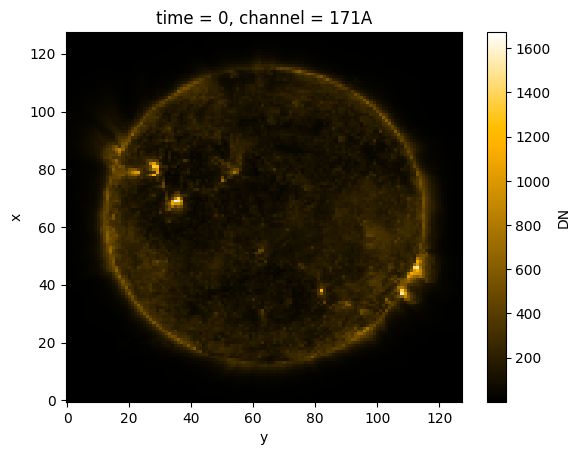

In [7]:
img = selected_channel.isel(time=0)
cmap = plt.get_cmap('sdoaia171')
img.plot(cmap=cmap)


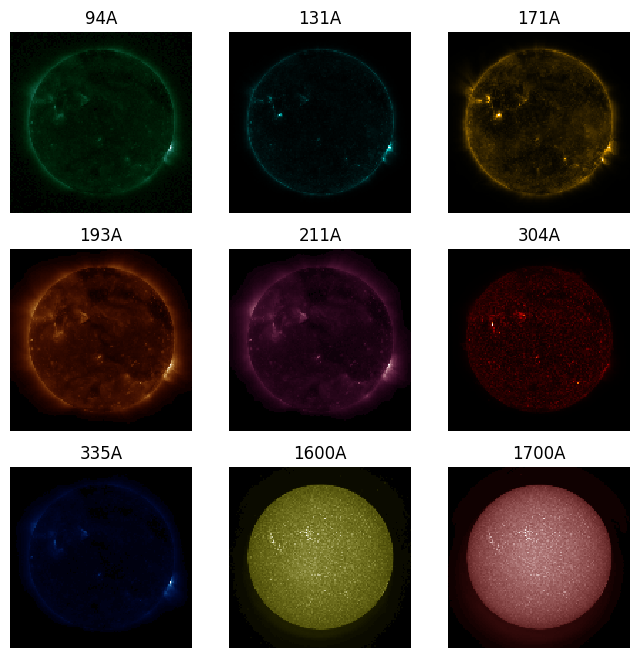

In [8]:
keys = natsorted(ds['channel'].data)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for ax, key in zip(axes.ravel(), keys):
    data = ds['DN'].sel(channel=key).isel(time=0)
    cmap = plt.get_cmap(f'sdoaia{key[:-1]}')
    im = data.plot(cmap=cmap, ax=ax, add_colorbar=False)
    ax.set_title(key)
    ax.axis('off')

plt.show()

1. Data Preparation
Input: AIA 94 Å channel image (shape: 128x128)

Target: The 8 missing AIA channels (shape: 8 x 128 x 128)

Normalization: Scale values between 0 and 1 or use z-score normalization per channel

Train/Test Split: e.g., 80% train, 20% test



In [1]:
# prompt: 1. Data Preparation
# Input: AIA 94 Å channel image (shape: 128x128)
# Target: The 8 missing AIA channels (shape: 8 x 128 x 128)
# Normalization: Scale values between 0 and 1 or use z-score normalization per channel
# Train/Test Split: e.g., 80% train, 20% test

# Normalize the data
def normalize_data(data):
    return (data - data.min()) / (data.max() - data.min())

# Assuming 'ds' is your xarray dataset as defined in the previous code
normalized_ds = ds.copy()
for channel in ds['channel'].data:
    normalized_ds['DN'].loc[dict(channel=channel)] = normalize_data(ds['DN'].sel(channel=channel))

# Split data into input (94A) and target (other 8 channels)
input_channel = normalized_ds['DN'].sel(channel='94A').data
target_channels = normalized_ds['DN'].sel(channel=lambda x: x != '94A').data


# Train/Test Split
train_size = int(0.8 * len(input_channel))  # 80% for training
input_train, input_test = input_channel[:train_size], input_channel[train_size:]
target_train, target_test = target_channels[:train_size], target_channels[train_size:]


print("Input Train shape:", input_train.shape)
print("Target Train shape:", target_train.shape)
print("Input Test shape:", input_test.shape)
print("Target Test shape:", target_test.shape)


NameError: name 'ds' is not defined

2. Model Architecture
A good choice would be a U-Net or a lightweight CNN encoder-decoder:

In [ ]:
# prompt: 2. Model Architecture
# A good choice would be a U-Net or a lightweight CNN encoder-decoder:

import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=8):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder
        self.dec1 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec3 = self.conv_block(128 + 64, 64)
        self.out = nn.Conv2d(64, out_channels, 1)

    def conv_block(self, in_c, out_c):
      return nn.Sequential(
          nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
          nn.ReLU(inplace=True)
      )

    def forward(self, x):
      # Encoder
      enc1 = self.enc1(x)
      enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
      enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
      enc4 = self.enc4(nn.MaxPool2d(2)(enc3))

      # Decoder
      dec1 = self.dec1(torch.cat([nn.Upsample(scale_factor=2)(enc4), enc3], dim=1))
      dec2 = self.dec2(torch.cat([nn.Upsample(scale_factor=2)(dec1), enc2], dim=1))
      dec3 = self.dec3(torch.cat([nn.Upsample(scale_factor=2)(dec2), enc1], dim=1))
      out = self.out(dec3)
      return out

# Example instantiation
model = UNet()
model


3. Training Loop with CodeCarbon
Use CodeCarbon to track energy usage during training.

In [ ]:
# prompt: 3. Training Loop with CodeCarbon
# Use CodeCarbon to track energy usage during training.

# Assuming input_train, target_train, input_test, target_test, and model are defined as in the previous code.

import torch.optim as optim
from tqdm import tqdm

# Define your optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Example: Adam optimizer
criterion = nn.MSELoss()  # Example: Mean Squared Error loss

# Convert data to tensors
input_train_tensor = torch.tensor(input_train, dtype=torch.float32).unsqueeze(1).unsqueeze(0) # Add channel and batch dimensions
target_train_tensor = torch.tensor(target_train, dtype=torch.float32).unsqueeze(0) # Add batch dimension

input_test_tensor = torch.tensor(input_test, dtype=torch.float32).unsqueeze(1).unsqueeze(0)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32).unsqueeze(0)

# Number of training epochs
num_epochs = 5 #@param {type:"number"}

@track_emissions(project_name="solar_image_reconstruction")
def train_model(model, num_epochs, input_train, target_train):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(input_train)
        loss = criterion(outputs, target_train)
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Train the model
train_model(model, num_epochs, input_train_tensor, target_train_tensor)




In [ ]:
# prompt: 4. Loss Function
# Use a pixel-wise loss like MSE or a combination of MSE + SSIM:

import torch.nn as nn

# Assuming criterion is defined as nn.MSELoss()
# and you want to add SSIM loss

from pytorch_msssim import ssim

# Define the combined loss function
def combined_loss(output, target, mse_weight=0.8, ssim_weight=0.2):
    mse_loss = nn.MSELoss()(output, target)
    ssim_loss = 1 - ssim(output, target, data_range=1.0)  # Assuming data is normalized to [0, 1]

    # Combine the losses
    combined = mse_weight * mse_loss + ssim_weight * ssim_loss

    return combined

#Example usage within the training loop:
#loss = combined_loss(outputs, target_train_tensor)


In [ ]:
# prompt: 5. Early Stopping Criteria
# You can define stopping based on minimal performance gain per energy unit:

# Define a threshold for minimal performance gain
min_performance_gain = 0.001 #@param {type:"number"}
min_energy_gain = 0.1 #@param {type:"number"}


# Initialize variables to track performance and energy
previous_loss = float('inf')
previous_emissions = 0

# ... (Your existing code for model training) ...

@track_emissions(project_name="solar_image_reconstruction")
def train_model(model, num_epochs, input_train, target_train):
    global previous_loss, previous_emissions
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(input_train)
        loss = combined_loss(outputs, target_train)
        loss.backward()
        optimizer.step()

        current_emissions = codecarbon.EmissionsTracker().emissions  # Assuming codecarbon is imported as above
        emissions_diff = current_emissions - previous_emissions

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Emissions: {current_emissions:.4f} kg CO2eq, Emissions Difference: {emissions_diff:.4f} kg CO2eq")

        # Check for early stopping
        performance_gain = previous_loss - loss.item()
        if performance_gain < min_performance_gain and emissions_diff < min_energy_gain:
            print(f"Early stopping at epoch {epoch+1}. Performance gain and energy gain are below the threshold")
            break

        previous_loss = loss.item()
        previous_emissions = current_emissions

# Train the model
train_model(model, num_epochs, input_train_tensor, target_train_tensor)


In [ ]:
# prompt: 6. Evaluation Metrics
# PSNR (Peak Signal-to-Noise Ratio)
# SSIM (Structural Similarity Index)
# Compare reconstructed channels with true images

# ... (Your existing code) ...

# Calculate PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# Calculate SSIM per channel
def ssim_per_channel(output, target):
  ssim_values = []
  for i in range(output.shape[1]): # Iterate through channels
      ssim_values.append(ssim(output[:,i,:,:], target[:,i,:,:], data_range=1.0).item())
  return ssim_values

# ... (Inside your training loop or evaluation function) ...
with torch.no_grad():
    outputs = model(input_test_tensor)
    # Calculate PSNR and SSIM for each channel
    psnr_values = []
    ssim_channel_values = ssim_per_channel(outputs, target_test_tensor)
    for i in range(outputs.shape[1]):
        psnr_values.append(psnr(outputs[0,i,:,:].numpy(), target_test_tensor[0,i,:,:].numpy()))

    print("PSNR values per channel:", psnr_values)
    print("SSIM values per channel:", ssim_channel_values)

    # Average PSNR and SSIM across all channels
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_channel_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")


In [ ]:
# prompt: 7. Output
# Predicted 8-channel AIA images
# CodeCarbon emission log file (appended on each run)
# Evaluation metrics

# Assuming 'model' and 'input_test_tensor' are defined as in the previous code.
# Also assuming 'target_test_tensor' is defined.

import matplotlib.pyplot as plt
import numpy as np

# ... (Your existing code) ...


with torch.no_grad():
    predicted_images = model(input_test_tensor)

    # Reshape for plotting
    predicted_images = predicted_images.squeeze(0).numpy()

    # Plot predicted images
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, ax in enumerate(axes.flatten()):
      if i < 8:  # Check if within the number of predicted images
          ax.imshow(predicted_images[i], cmap='gray') # Assuming grayscale images, change 'gray' if needed
          ax.set_title(f'Predicted Channel {i+1}')
          ax.axis('off')
      else:
          ax.axis('off')

    plt.show()

    # Log codecarbon emissions (assuming you're using codecarbon as before)
    with open("codecarbon_log.txt", "a") as f:
        f.write(str(codecarbon.EmissionsTracker().emissions) + "\n")

    # Print evaluation metrics (PSNR and SSIM)
    # ... (Your existing PSNR and SSIM calculation code from previous response) ...
